In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
rng = np.random.default_rng()

In [2]:
def ordered_state(width):
    return np.exp(2j * np.pi * np.zeros((width,width,width,width,4)))

def disordered_state(width):
    return np.exp(2j * np.pi * np.random.rand(width,width,width,width,4))

def run_lattice_heatbath(state,beta,n):
    """Perform n heatbath updates on the lattice state."""
    for _ in range(n):
        lattice_heatbath_update(state,beta)

def lattice_heatbath_update(state,beta):
    """Perform a heatbath update on a random link in the lattice state."""
    width = len(state)
    link_index = random_link_index(width)
    state[link_index] = sample_link_variable(state,beta,link_index)

def random_link_index(width):
    """Return a random link index (n_x,n_y,n_z,kappa)."""
    return tuple(rng.integers(0,[width,width,width,width,4]))

def sample_link_variable(state,beta,link_index):
    """Sample link variable U = exp(i*theta)."""
    link_variable_sum = relevant_link_variable_sum(state,link_index)
    alpha = beta*np.real(link_variable_sum)
    phi = np.angle(link_variable_sum)
    while True:
        Z = rng.uniform(0,1)
        x = -1 + np.log(1 + (np.exp(2*alpha) - 1)*Z)/alpha

        Q = np.exp(alpha*(np.cos(np.pi/2*(1-x))-x))
        Q_max = np.exp(0.2105137*alpha)

        Z_prime = rng.uniform(0,1)
        if Q/Q_max > Z_prime:
            theta = np.pi*(1-x)/2 - phi
            return np.exp(1j*theta)

def relevant_link_variable_sum(state,link_index):
    """Return the sum of the link variables present in the plaquettes containing the relevant link,
    without the contribution of the link itself."""
    width = len(state)
    n = np.array(link_index[:4])
    kappa = link_index[-1]
    kappa_hat = np.array(get_unit_vector(kappa))

    link_variable_sum = 0
    for nu in range(4):
        if nu != kappa:
            nu_hat = get_unit_vector(nu)
            contribution = state[get_lattice_vector(n+kappa_hat,width)][nu]
            contribution *= state[get_lattice_vector(n+nu_hat,width)][kappa]
            contribution *= state[get_lattice_vector(n,width)][nu]
            link_variable_sum += contribution

    return link_variable_sum

def get_unit_vector(index):
    """Return the unit vector from the dimension index."""
    vector = np.zeros(4).astype(int)
    vector[index] = 1
    return vector

def get_lattice_vector(vector,width):
    """Get the lattice vector periodic with the lattice size."""
    return tuple(map(lambda i: i % width, vector))

def average_plaquette_action(state):
    """Compute action of the lattice state."""
    width = len(state)

    action = 0
    for n in lattice_vertices(width):
        for mu in range(4):
            for nu in range(4):
                if mu < nu:
                    mu_hat, nu_hat = get_unit_vector(mu), get_unit_vector(nu)
                    contribution = state[get_lattice_vector(n,width)][mu]
                    contribution *= state[get_lattice_vector(n+mu_hat,width)][nu]
                    contribution *= state[get_lattice_vector(n+nu_hat,width)][mu]
                    contribution *= state[get_lattice_vector(n,width)][nu]
                    action += (1 - np.real(contribution))

    num_plaquettes = width*width*width*width*6
    return action / num_plaquettes

def lattice_vertices(width):
    """Compute the vertices of the lattice with given width."""
    vertices = []
    for n_x in range(width):
        for n_y in range(width):
            for n_z in range(width):
                for n_t in range(width):
                    vertex = (n_x,n_y,n_z,n_t)
                    vertices.append(vertex)
    return vertices

def run_simulation(state,beta,k,n,measurements):
    """Run the simulation with k equilibration sweeps and n measurement sweeps.
    Returns the action measurement results."""
    width = len(state)
    num_links = width*width*width*width*4

    # equilibrate
    run_lattice_heatbath(state,beta,k*num_links)

    # measure
    results = np.empty(measurements)
    for i in range(measurements):
        run_lattice_heatbath(state,beta,n*num_links)
        results[i] = average_plaquette_action(state)
        print(f"Running... ({i+1} / {measurements})")

    print("Completed run")
    return results

def try_gather_data_and_plot(state,beta,k,n,measurements):
    try_gather_data(state,beta,k,n,measurements)
    try_plot_data(len(state),beta,measurements)

def try_gather_data(state,beta,k,n,measurements):
    with h5py.File('lattice.hdf5','a') as f:
        width = len(state)
        if not f"actions_w{width}_b{np.round(beta,decimals=2)}" in f:
            actions = run_simulation(state,beta,k,n,measurements)
            f.create_dataset(f"actions_w{width}_b{np.round(beta,decimals=2)}",data=actions)

def try_plot_data(width,beta,measurements):
    with h5py.File('lattice.hdf5','r') as f:
        average_plaquette_actions = f[f"actions_w{width}_b{np.round(beta,decimals=2)}"][()]

        plt.scatter(np.linspace(1,measurements,measurements),average_plaquette_actions)
        plt.xlabel("iterations")
        plt.ylabel("average action per plaquette")

        plt.plot(np.linspace(1,measurements,measurements),[np.mean(average_plaquette_actions) for _ in range(measurements)],color="orange")

        print(f"Mean: {np.mean(average_plaquette_actions)}")

In [3]:
# Tijmen

beta_values = np.arange(0.5, 3, 0.1)

for beta_value in beta_values:
    try_gather_data_and_plot(state=ordered_state(width=5),beta=beta_value,k=0,n=1,measurements=6000)

In [4]:
# # Ties

beta_values = np.arange(3, 6, 0.1)

for beta_value in beta_values:
    try_gather_data_and_plot(state=ordered_state(width=5),beta=beta_value,k=0,n=1,measurements=6000)

Text(0, 0.5, '$\\langle E \\rangle$')

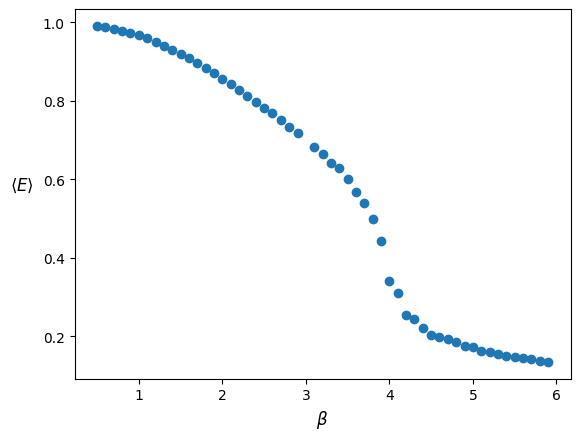

In [19]:
mean_actions = []

beta1s = np.arange(0.5, 3, 0.1)
with h5py.File('data/presentation1.hdf5','r') as f:
    for beta1 in beta1s:
        actions = f[f"actions_w4_b{np.round(beta1,decimals=2)}"][()]
        mean_actions.append(np.mean(actions))

beta2s = np.arange(3.1, 6, 0.1)
with h5py.File('data/presentation2.hdf5','r') as f:
    for beta2 in beta2s:
        actions = f[f"actions_w4_b{np.round(beta2,decimals=2)}"][()]
        mean_actions.append(np.mean(actions))

betas = np.concatenate([beta1s, beta2s])

plt.scatter(betas,mean_actions)
plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'$\langle E \rangle$', rotation=0, labelpad=15, fontsize=12)